# DP0.2 Object Catalog tutorial -- Part IV: Running DESCQA

Owners: **PatriciaLarsen [@plarsen](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@patricialarsen)**  
Last Verifed to Run: **2024-06-04** (by @plarsen)

This notebook will show you how to run the DESCQA validation tools. We'll go over a list of the existing validation tools, and show you how to submit jobs to run them and how to look at the results. 

__This is currently on the DC2 data, 

__Learning objectives__:

After going through this notebook, you should be able to:
  1. Run the DESCQA validation tools and look at the results
  2. Understand the existing tools 
  3. Know how to contribute new tools

  
__Important Notes__:
- This is in constant development, if you'd like to contribute please ping Patricia for help. If you'd like a validation tool incorporated or tracked please contact the SRV group. 


__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter+at+NERSC


## DP0.2 

This notebook will be updated to show how to do all this with the DP0.2 data and the SRV tests. The main changes are to use the SRV branch of DESCQA and the GCRCatalogs version mentioned in previous tutorials. A lot of the information is available here: https://docs.google.com/presentation/d/1ar-4lpOetJBX71M6LQeSqHLWoKzpJ1i0QpuVi8iJsO0/edit?usp=sharing

To get started download DESCQA from the github here:

```url
https://github.com/LSSTDESC/descqa
```
and then checkout the "SRV" branch. We don't currently have the SRV branch installed into the DESC kernels, this will likely change in future. 


For the rest of the notebook this currently shows how to run the standard DESCQA in a notebook.


## DC2

First let's start by doing some imports and defining some functions

In [132]:
import yaml
import importlib
import fnmatch
import glob

from PIL import Image
from IPython.display import display


def select_subset(available, wanted=None):
    if wanted is None:
        available_default = None
        if isinstance(available, dict):
            available_default = [k for k, v in available.items() if v.get('included_by_default') or v.get('include_in_default_catalog_list')]
        return set(available_default) if available_default else set(available)
        
    wanted = set(wanted)
    output = set()

    for item in wanted:
        matched = fnmatch.filter(available, item)
        if not matched:
            raise KeyError("{} does not match any available names: {}".format(item, ', '.join(sorted(available))))
        output.update(matched)

    return tuple(sorted(output))


def interpret_result(test_result):
    print("Status code:")
    print(test_result.status_code)
    print()
    if test_result.inspect_only:
        print("No pass/fail criterion specified, inspection only")
    elif test_result.passed:
        print("Test passed!")
    else:
        print("Test failed!")
    print()
    print("Summary message:")
    print(test_result.summary)
    return 

In [133]:
GCRCatalogs = importlib.import_module('GCRCatalogs')
descqa = importlib.import_module('descqa')

Now let's decide on which tests to run. SkyArea is a nice simple test that I often use if I need a check that descqa is running correctly, so let's use that. We're using it on the small cosmoDC2 catalog as that will load fairly quickly. 

In [134]:
validations_to_run = ['SkyArea']
catalogs_to_run = ['cosmoDC2_v1.1.4_small']


In actually loading these we first confirm that they're available within the GCRCatalogs and DESCQA versions you've imported

In [135]:
# let's just confirm these exist first of all - will raise a big red error if you've got the wrong name!

validations_to_run = select_subset(descqa.available_validations, validations_to_run)
catalogs_to_run = select_subset(GCRCatalogs.get_available_catalogs(False), catalogs_to_run)
if not validations_to_run or not catalogs_to_run:
    raise RuntimeError('Nothing to run... Aborted!')
    


And now we load the catalog and the validation class. 

In [136]:
# now let's load the catalogs, since we're running this interactively we're skipping the exception catching 
catalog_instances={}
for catalog in catalogs_to_run:
    catalog_instances[catalog] = GCRCatalogs.load_catalog(catalog)
validation_instances={}
for validation in validations_to_run:
    validation_instances[validation] = descqa.load_validation(validation)


Finally let's tell it where to output the data, and then ask the validation class to run on the catalog!

In [137]:
output_dir_this = './test_direc'  # point to a directory where you want to store any plots or results
test_result = validation_instances[validation].run_on_single_catalog(catalog_instances[catalog], catalog, output_dir_this)

All the results will output in the folder you've specified, however there is some information from the test_result itself, I've made a little convenience function to output the information from there:

In [138]:
interpret_result(test_result)

Status code:
VALIDATION_TEST_INSPECT

No pass/fail criterion specified, inspection only

Summary message:
approx. 72.5989 sq. deg.


And let's grab the output sky area image and plot it in the notebook! 

./test_direc/skymap.png


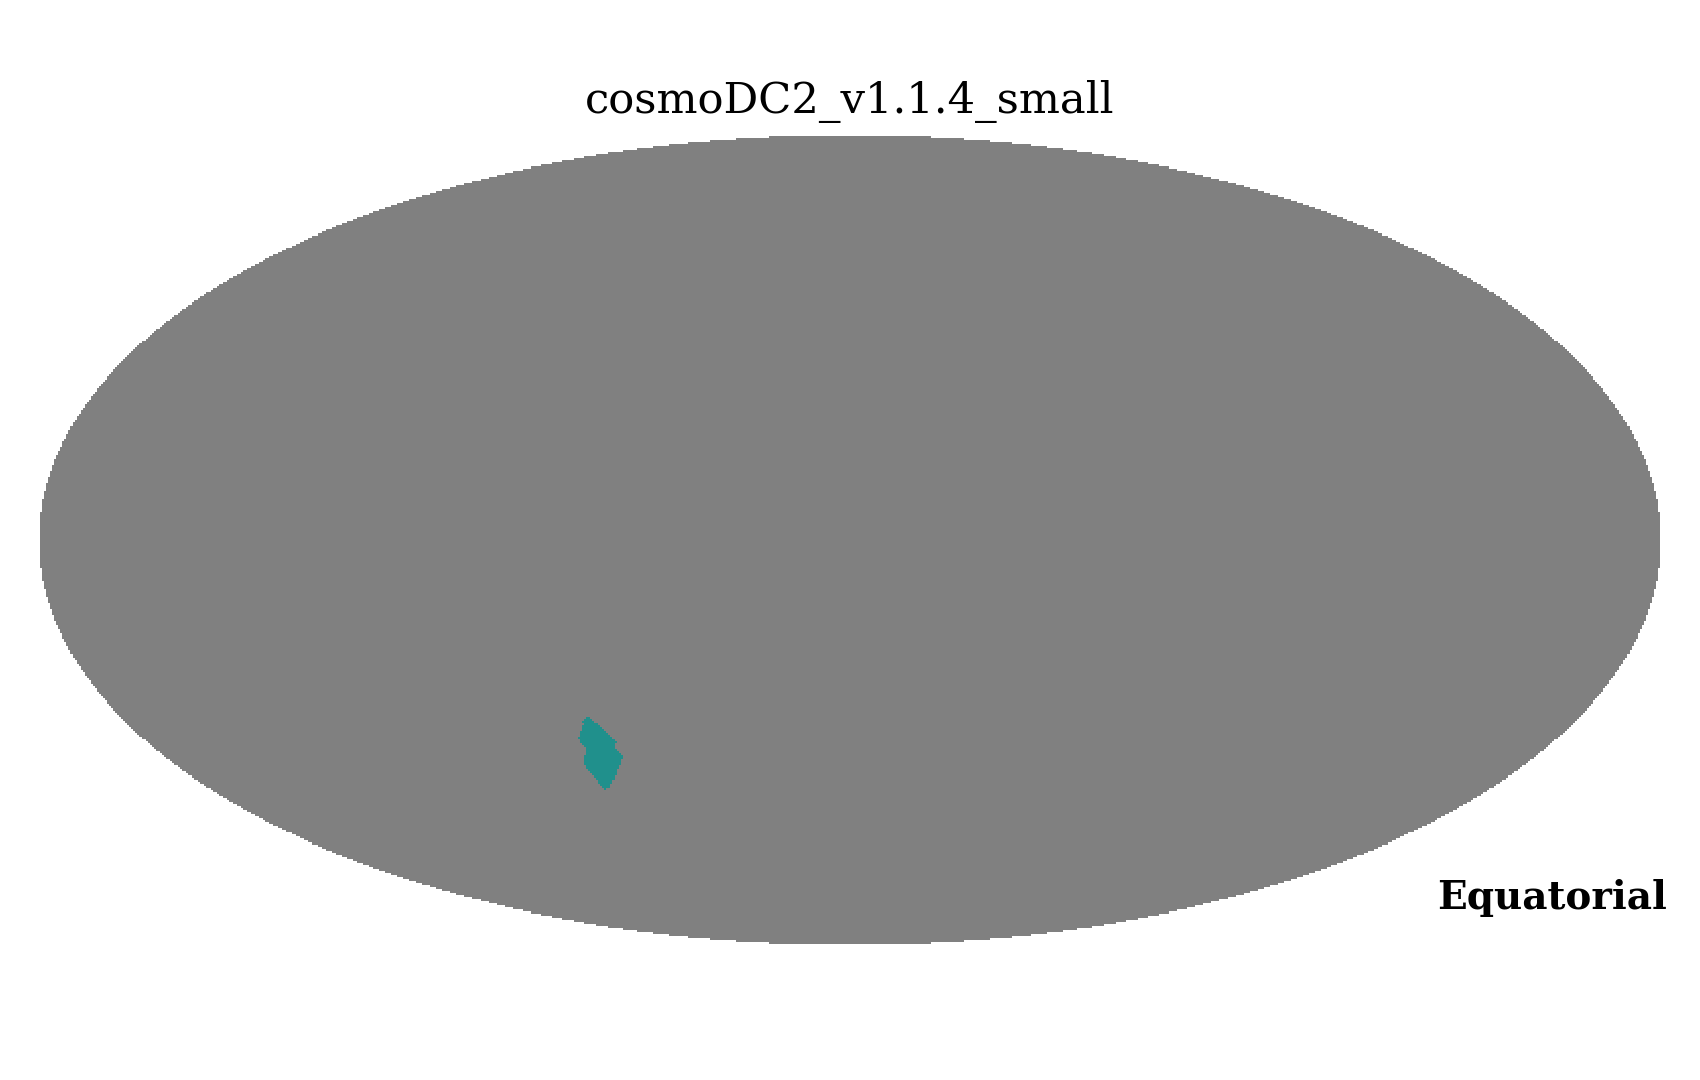

In [139]:
for image in glob.glob( output_dir_this + '/*.png'):
    print(image)
    display(Image.open(image))

### Development

Okay so we can run the tests, but can we actually develop them in the notebook? Sure! Let's copy that test class here and edit it to change the color of the map.  

In [140]:
#let's have a look at the test 
from descqa.base import BaseValidationTest, TestResult
import numpy as np
import healpy as hp
import os
import matplotlib.pyplot as plt
import matplotlib as mpl


class SkyArea2(BaseValidationTest):
    """
    validation test to show sky area
    """
    def __init__(self, **kwargs): #pylint: disable=W0231
        self.nside = kwargs.get('nside', 64)
        assert hp.isnsideok(self.nside), '`nside` value {} not correct'.format(self.nside)


    def run_on_single_catalog(self, catalog_instance, catalog_name, output_dir):
        if not catalog_instance.has_quantities(['ra_true', 'dec_true']):
            return TestResult(skipped=True)
        
        print("This is being developed locally!")

        pixels = set()
        for d in catalog_instance.get_quantities(['ra_true', 'dec_true'], return_iterator=True):
            pixels.update(hp.ang2pix(self.nside, d['ra_true'], d['dec_true'], lonlat=True))

        frac = len(pixels) / hp.nside2npix(self.nside)
        skyarea = frac * np.rad2deg(np.rad2deg(4.0*np.pi))

        hp_map = np.empty(hp.nside2npix(self.nside))
        hp_map.fill(hp.UNSEEN)
        hp_map[list(pixels)] = 0
        cmap = mpl.colormaps['magma']

        hp.mollview(hp_map, title=catalog_name, coord='C', cbar=None, cmap=cmap)
        plt.savefig(os.path.join(output_dir, 'skymap.png'))
        plt.close()
        return TestResult(inspect_only=True, summary='approx. {:.7g} sq. deg.'.format(skyarea))

We now just need to create a dictionary of input arguments to pass in, and then we can initialize the class with those arguments as our 
validation

In [141]:
# we need to create an input dictionary to give any arguments required in the __init__ code, then we just initialize and run!
dict_config = {}
dict_config['nside'] = 128
dict_config['description'] = 'Displaying the sky coverage of each catalog'

validation2 = SkyArea2(**dict_config)

And we run it as before, swapping out the validation class

In [142]:
output_dir_this = './test_direc'  # point to a directory where you want to store any plots or results
test_result = validation2.run_on_single_catalog(catalog_instances[catalog], catalog, output_dir_this)

This is being developed locally!


In [143]:
interpret_result(test_result)

Status code:
VALIDATION_TEST_INSPECT

No pass/fail criterion specified, inspection only

Summary message:
approx. 72.5989 sq. deg.


./test_direc/skymap.png


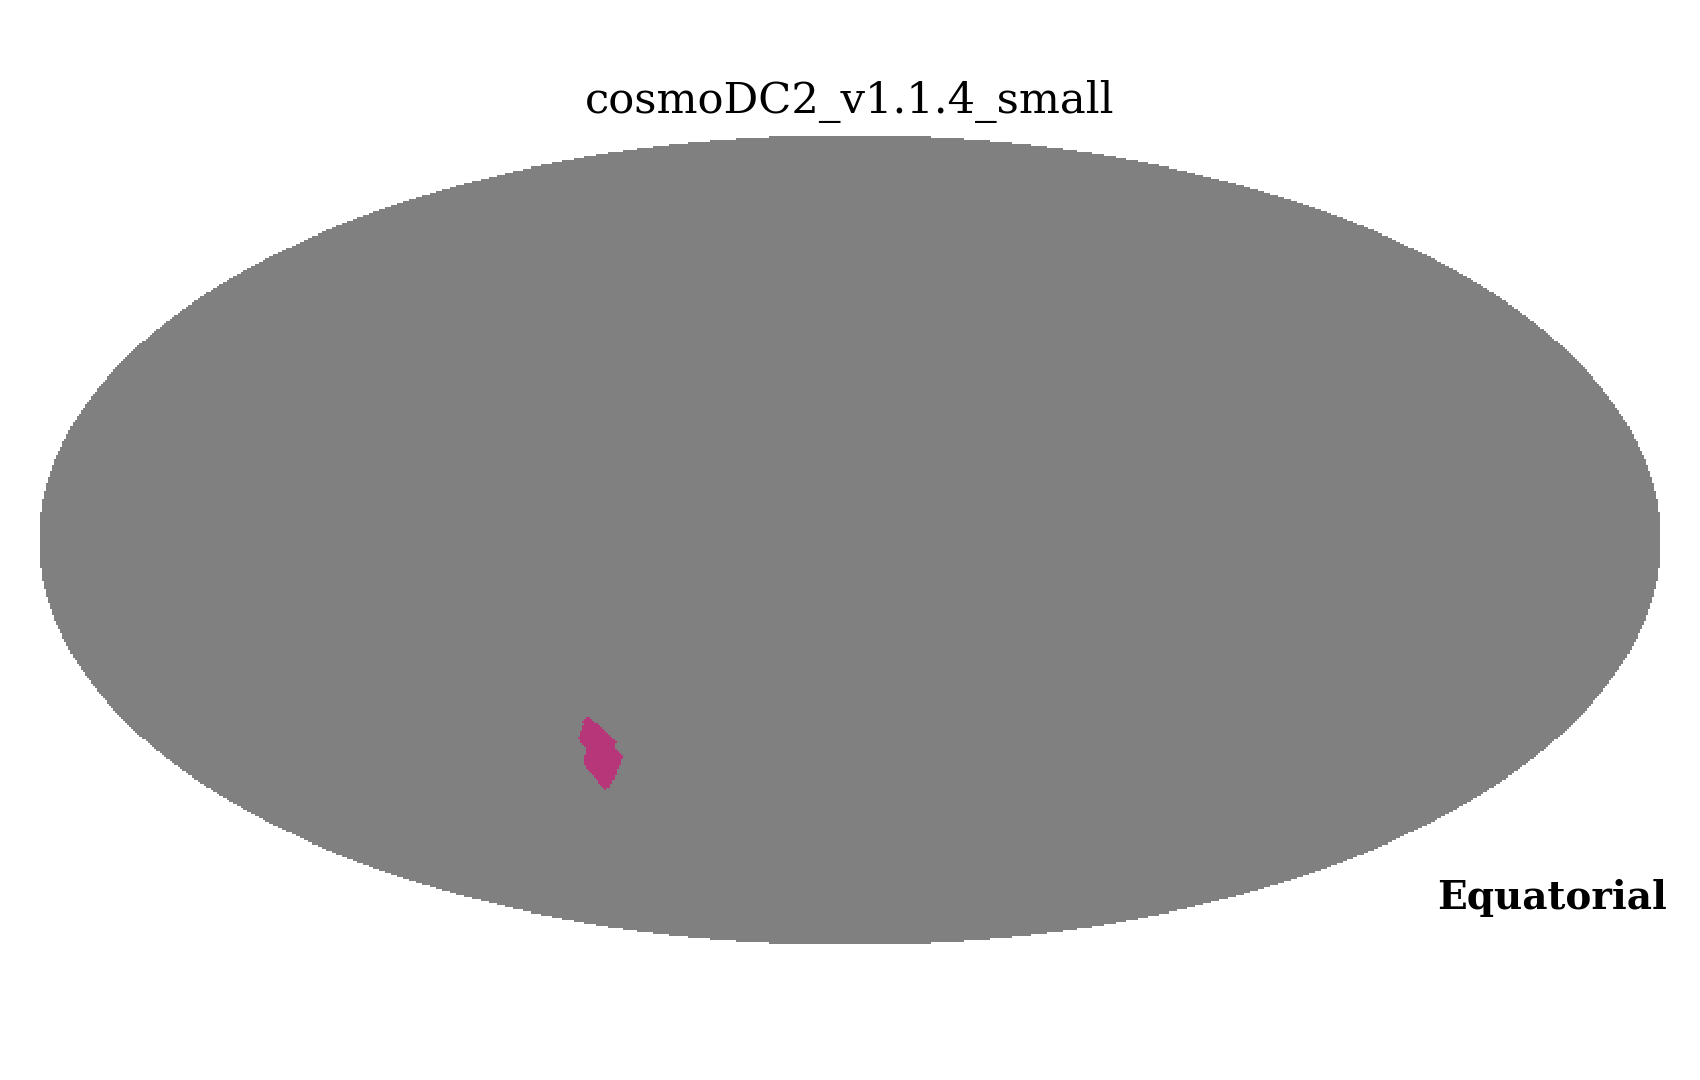

In [144]:
for image in glob.glob( output_dir_this + '/*.png'):
    print(image)
    display(Image.open(image))

## Passing in data

But what about when we're developing quickly and we don't want to load the data every time? Well when committing these tests we'll need to know how to get the data, but for quick re-runs you can always load the data externally and pass it in through the dictionary. This also works when there's a more expensive step but you just want to alter the output formatting. Let's say I really don't like either color and I want to mess around with more colormaps.  

In [150]:
## Now if we want to truly run and alter this interactively we might not want to waste time on IO, so why don't we pass in 
#the data as a dictionary in the meantime?


class SkyArea3(BaseValidationTest):
    """
    validation test to show sky area
    """
    def __init__(self, **kwargs): #pylint: disable=W0231
        self.nside = kwargs.get('nside', 64)
        self.data = kwargs.get('data')
        assert hp.isnsideok(self.nside), '`nside` value {} not correct'.format(self.nside)


    def run_on_single_catalog(self, catalog_instance, catalog_name, output_dir):
        if not catalog_instance.has_quantities(['ra_true', 'dec_true']):
            return TestResult(skipped=True)
        
        print("Data is being passed in")

        pixels = set()
        pixels.update(hp.ang2pix(self.nside, self.data['ra_true'], self.data['dec_true'], lonlat=True))

        frac = len(pixels) / hp.nside2npix(self.nside)
        skyarea = frac * np.rad2deg(np.rad2deg(4.0*np.pi))

        hp_map = np.empty(hp.nside2npix(self.nside))
        hp_map.fill(hp.UNSEEN)
        hp_map[list(pixels)] = 0
        cmap = mpl.colormaps['Pastel1']

        hp.mollview(hp_map, title=catalog_name, coord='C', cbar=None, cmap=cmap)
        plt.savefig(os.path.join(output_dir, 'skymap.png'))
        plt.close()
        return TestResult(inspect_only=True, summary='approx. {:.7g} sq. deg.'.format(skyarea))

The only added step I need is to take out that data read, and put it externally (note that we load the whole dataset here not an iterative chunk). 

In [151]:
d = catalog_instances[catalog].get_quantities(['ra_true', 'dec_true'], return_iterator=False)

dict_config = {}
dict_config['data'] = d
dict_config['nside'] = 128
dict_config['description'] = 'Displaying the sky coverage of each catalog'


In [156]:
validation3 = SkyArea3(**dict_config)


And now we just run the test without the read-in and can see what the new color looks like

In [157]:
output_dir_this = './test_direc'  # point to a directory where you want to store any plots or results
test_result = validation3.run_on_single_catalog(catalog_instances[catalog], catalog, output_dir_this)

Data is being passed in


In [158]:
interpret_result(test_result)

Status code:
VALIDATION_TEST_INSPECT

No pass/fail criterion specified, inspection only

Summary message:
approx. 72.5989 sq. deg.


./test_direc/skymap.png


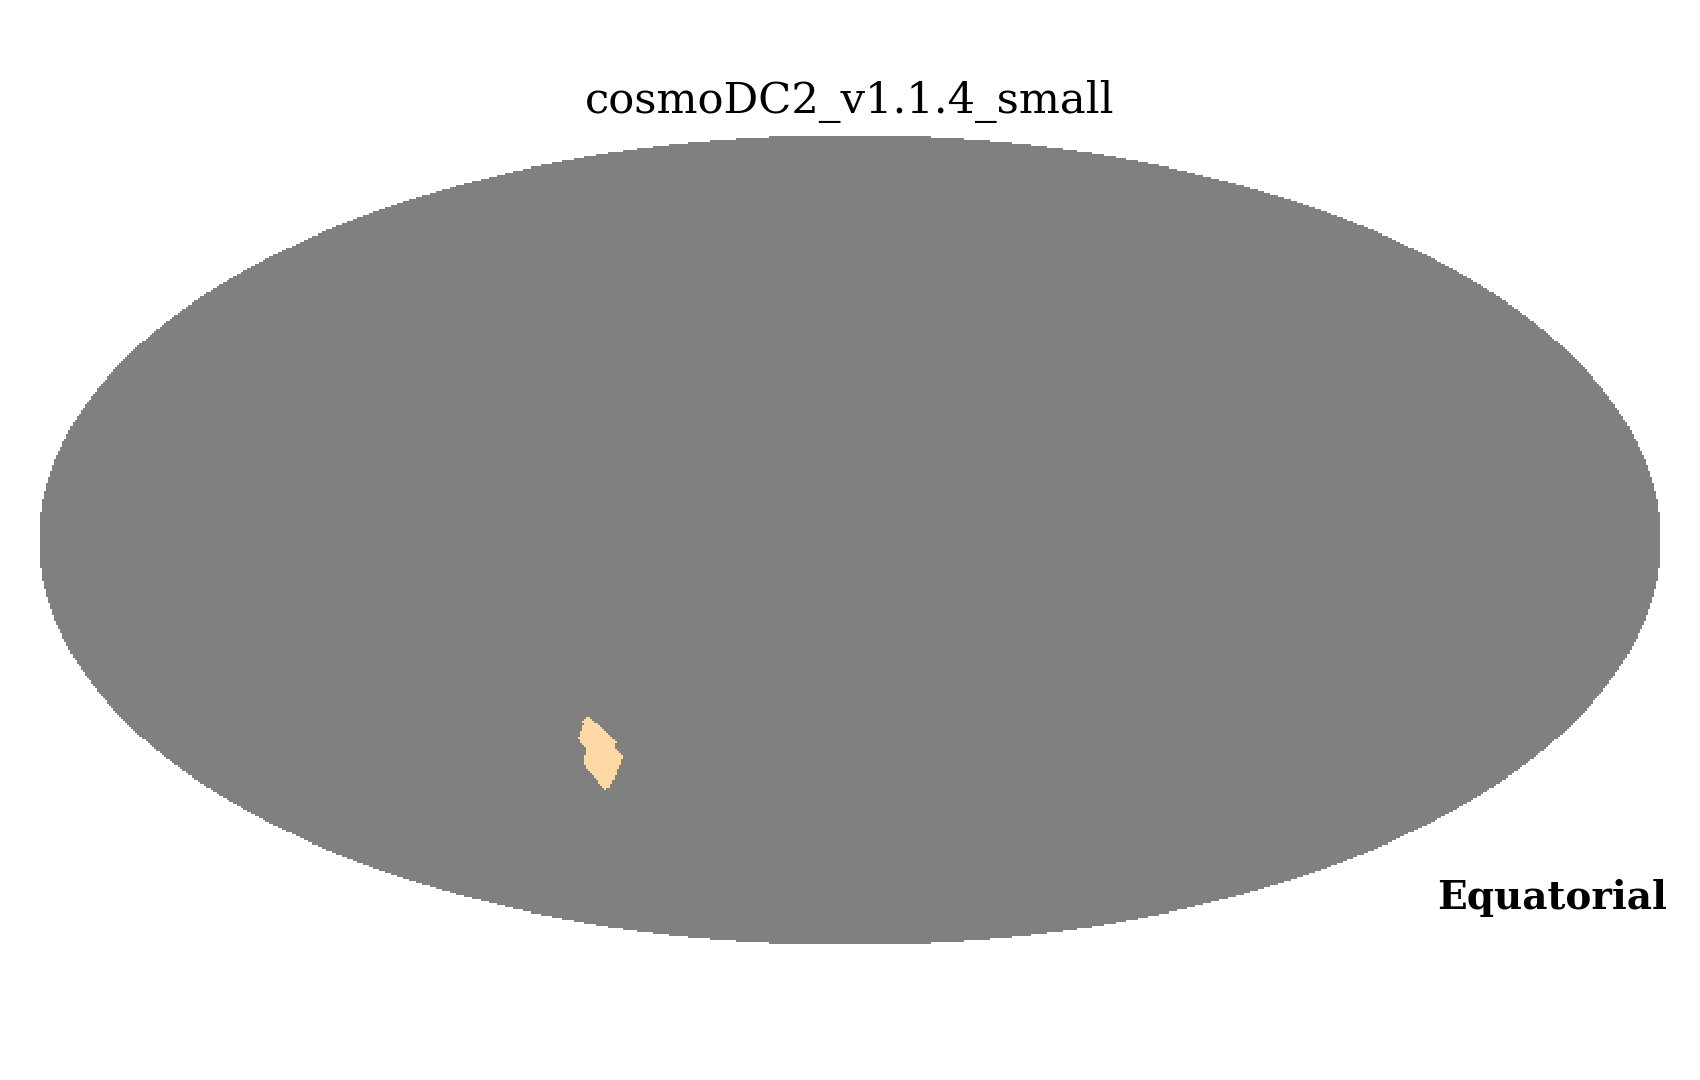

In [159]:
for image in glob.glob( output_dir_this + '/*.png'):
    print(image)
    display(Image.open(image))